# Mask R-CNN - Inspect WorkTool Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.
- Note: Code adapted from project https://github.com/matterport/Mask_RCNN 

In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library


import model as modellib
from model import log

# Import visualization functions    
from model import display_instances, display_images, draw_boxes #, display_top_masks
#from model import  random_colors, draw_rois, draw_box

# Import utility functions
from model import apply_box_deltas, denorm_boxes, non_max_suppression, denorm_boxes, unmold_mask
from model import compute_ap_range, compute_ap

import worktool

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "./")

# Path to worktool trained weights
WORKTOOL_WEIGHTS_PATH = "./mask_rcnn_worktool.h5" 


def LoadImage(imagefile):
    img= cv2.imread(imagefile)
    img= cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

Using TensorFlow backend.


## Configurations

In [26]:
config = worktool.WorkToolConfig()
WORKTOOL_DIR = os.path.join(ROOT_DIR, "datasets")

# Make sure you set it to 1 BG + the number of classes you are predicting
# See worktool.py
print("Number of classes: ", config.NUM_CLASSES)

Number of classes:  3


In [27]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    VALIDATION_STEPS = 100
    RPN_NMS_THRESHOLD = 0.3
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_MAX_INSTANCES = 20
    BATCH_SIZE = 1
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        20
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTAN

## Notebook Preferences

In [28]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [29]:
def get_ax(rows=1, cols=1, size=12):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [30]:
# Load validation dataset
dataset_val = worktool.WorkToolDataset()
dataset_val.load_worktool(WORKTOOL_DIR, "val")
dataset_val.prepare() # Must call before using the dataset

print("Images: {}\nClasses: {}".format(len(dataset_val.image_ids), dataset_val.class_names))


Images: 26
Classes: ['BG', 'hammer', 'spanner']


## Load Model

In [31]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [36]:
# Set path to worktool weights file
# Download file from the Releases page and set its path
# weights_path = "/path/to/mask_rcnn_worktool.h5"

# Or, load the last model you trained
# weights_path = model.find_last()[1]

WORKTOOL_WEIGHTS_PATH = "./mask_rcnn_worktool_v2.h5" 
weights_path = WORKTOOL_WEIGHTS_PATH
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  ./mask_rcnn_worktool_v2.h5


## Run Detection
### Test detection on images that are not found on training or test sets
- image1.jpg to image35.jpg located in ./datasets/images

Processing 1 images
image                    shape: (800, 800, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


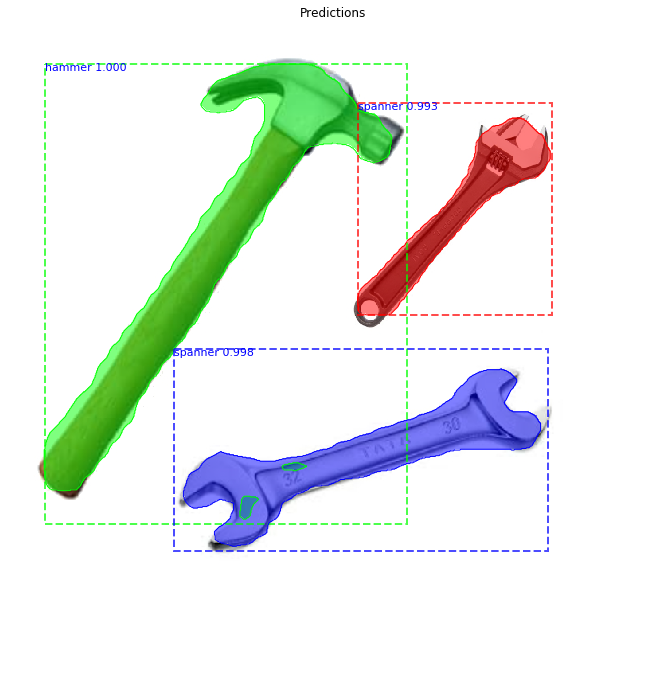

In [49]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array


image2Detect = load_img('./datasets/images/image30.jpg') 
# Some good examples: image6.jpg, image8.jpg, image23.jpg, image24.jpg, image28.jpg, image30.jpg
# Some fair examples: image12.jpg, image21.jpg, image25.jpg, image27.jpg, image29.jpg, image32.jpg

image2Detect = img_to_array(image2Detect)

# Run object detection
results = model.detect([image2Detect], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
display_instances(image2Detect, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=ax,
                            title="Predictions")


## Precision-Recall Curve and mAP
### Examine a sample class

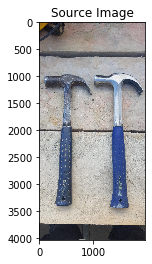

In [48]:
import matplotlib.pyplot as plt
image_id = dataset_val.image_ids[3] 
imagefile = dataset_val.image_reference(image_id)
plt.title("Source Image") 
plt.imshow(LoadImage(imagefile))



image ID: worktool.image4.jpg (3) C:\Work\ISS Masters in Tech Intelligent Systems\ISY5004\Vision systems (VSE)\CA1\report\source code\datasets\val\image4.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:  237.00000  max:  874.00000  int32
gt_mask                  shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  bool
AP @0.50:	 1.000
AP @0.55:	 1.000
AP @0.60:	 1.000
AP @0.65:	 1.000
AP @0.70:	 1.000
AP @0.75:	 1.000
AP @0.80:	 1.000
AP @0.85:	 0.000
AP @0.90:	 0.000
AP @0.95

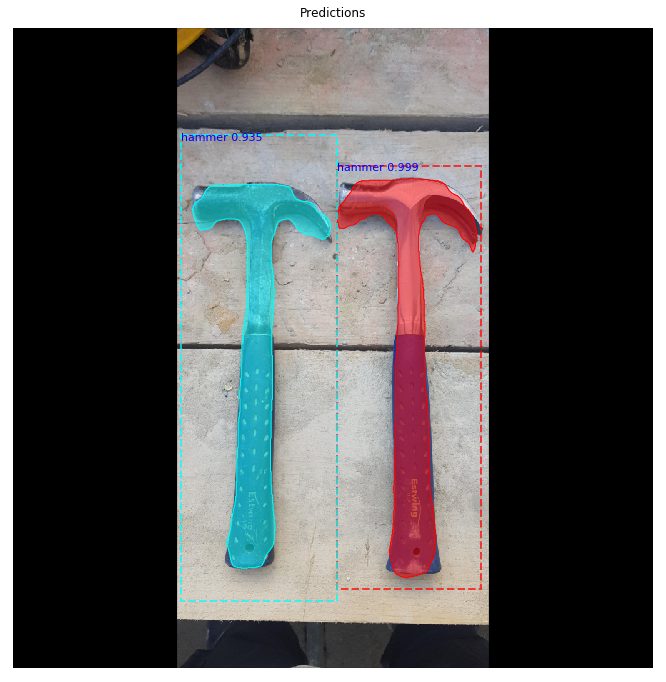

In [52]:

image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
info = dataset_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                    dataset_val.image_reference(image_id)))

#print("gt_class_ids: ", gt_class_ids.__class__ )

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]

display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Show mAP for ranges 0.50 to 0.95
mAP = compute_ap_range(gt_box=gt_bbox, gt_class_id=gt_class_id, 
                      gt_mask=gt_mask, pred_box=r['rois'],
                      pred_class_id=r['class_ids'], pred_score=r['scores'],
                      pred_mask=r['masks'])
print("mAP scores for ranges 0.50 to 0.95: ",mAP)
print("Prediction score: ", r['scores'])

print("precisions: ", precisions)
print("recalls: ", recalls)


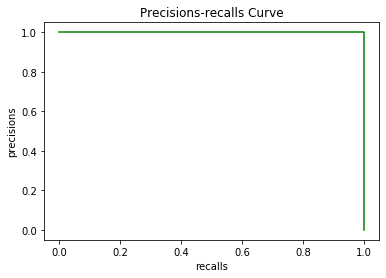

In [51]:
def PlotPRCurve(recallsList, precisionsList):    
    plt.plot(recallsList, precisionsList, color='g')
    plt.xlabel('recalls')
    plt.ylabel('precisions')
    plt.title('Precisions-recalls Curve')
    plt.show()
    
PlotPRCurve(recalls, precisions)

## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [53]:
image_id = dataset_val.image_ids[15] 
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
info = dataset_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                    dataset_val.image_reference(image_id)))
results = model.detect([image], verbose=1)
r = results[0]

image ID: worktool.image16.jpg (15) C:\Work\ISS Masters in Tech Intelligent Systems\ISY5004\Vision systems (VSE)\CA1\report\source code\datasets\val\image16.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


In [54]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (261888,)             min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -1.21094  max:    1.29426  float64
positive_anchors         shape: (9, 4)                min:   64.00000  max:  800.00000  float64
negative_anchors         shape: (247, 4)              min:  -96.00000  max: 1082.50967  float64
neutral anchors          shape: (261632, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (9, 4)                min:  138.00000  max:  788.00000  float32


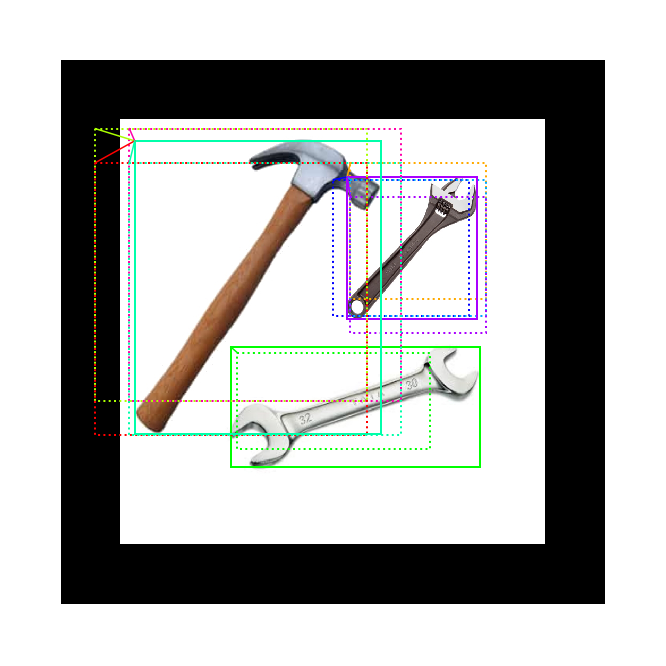

In [55]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [14]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 introduces a new version of NMS. Search for both names to support TF 1.3 and 1.4
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
 
if nms_node is None:
    #nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")

    nms_node = (model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
            or model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0"))
 
rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),    
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.35390  max:    1.29134  float32
refined_anchors          shape: (1, 6000, 4)          min: -5599.78857  max: 5600.61963  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


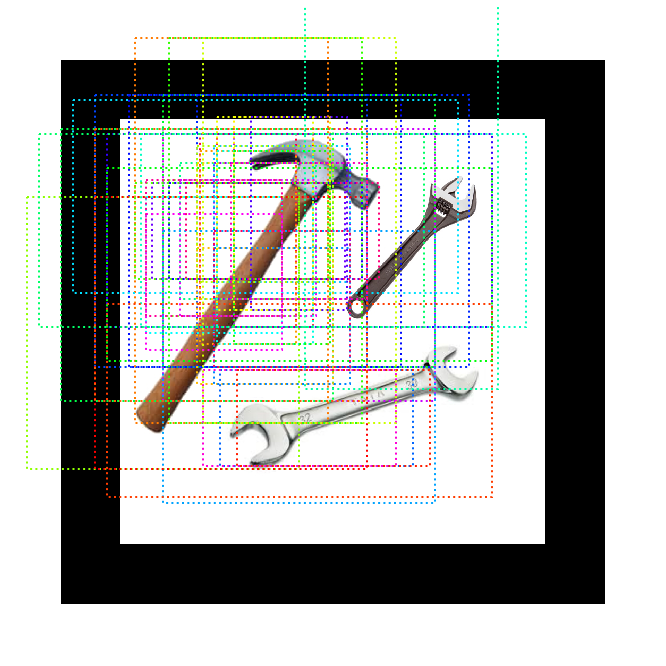

In [15]:
# Show top anchors by score (before refinement)
limit = 50
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

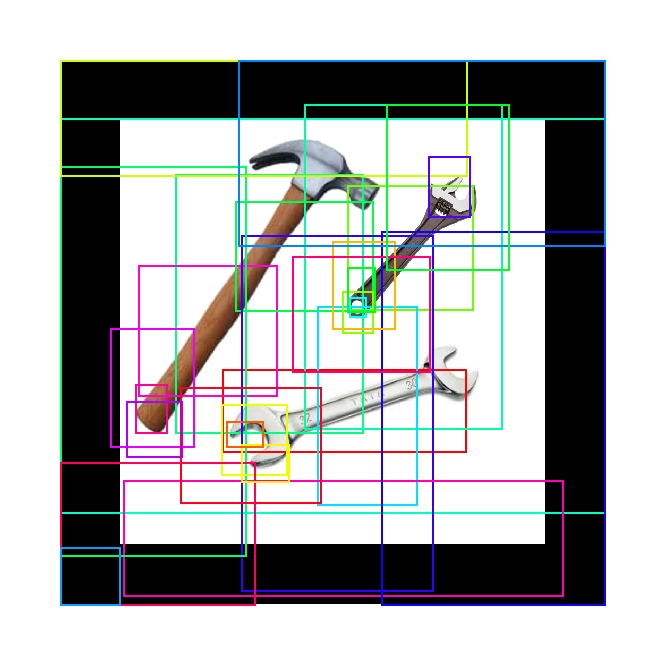

In [16]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
draw_boxes(image, refined_boxes=proposals, ax=get_ax())

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [17]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 3)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 3, 4)       min:   -3.95289  max:    4.50007  float32
masks                    shape: (1, 100, 28, 28, 3)   min:    0.00000  max:    0.99995  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    2.00000  float32


3 detections: ['spanner' 'spanner' 'hammer']


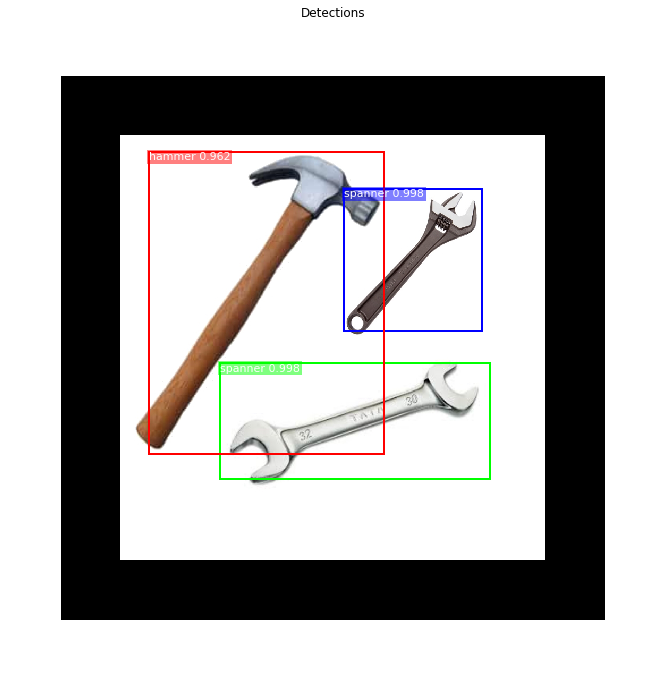

In [18]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset_val.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset_val.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
draw_boxes(
    image, 
    refined_boxes = denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [19]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset_val.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

30 Valid proposals out of 1000
3 Positive ROIs
[('BG', 997), ('hammer', 1), ('spanner', 2)]


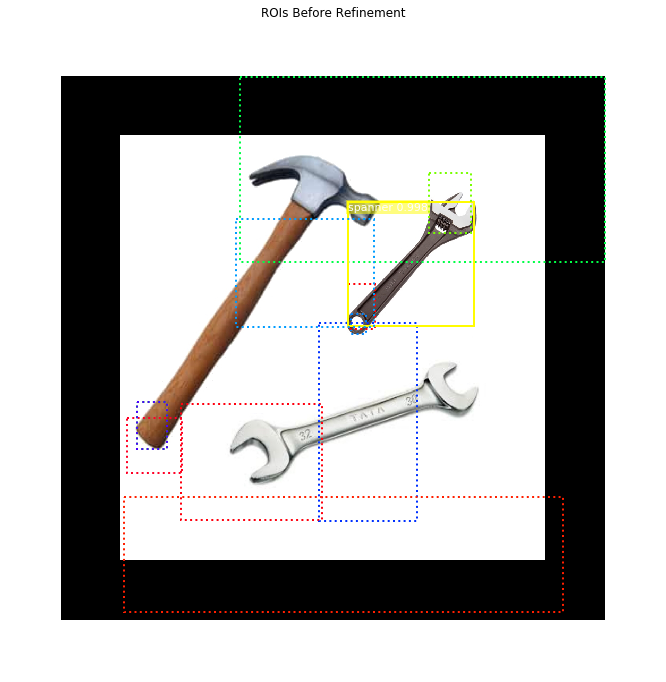

In [23]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset_val.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1000, 4)             min:   -2.02797  max:    2.49237  float32
refined_proposals        shape: (1000, 4)             min:  -73.00000  max: 1067.00000  int32


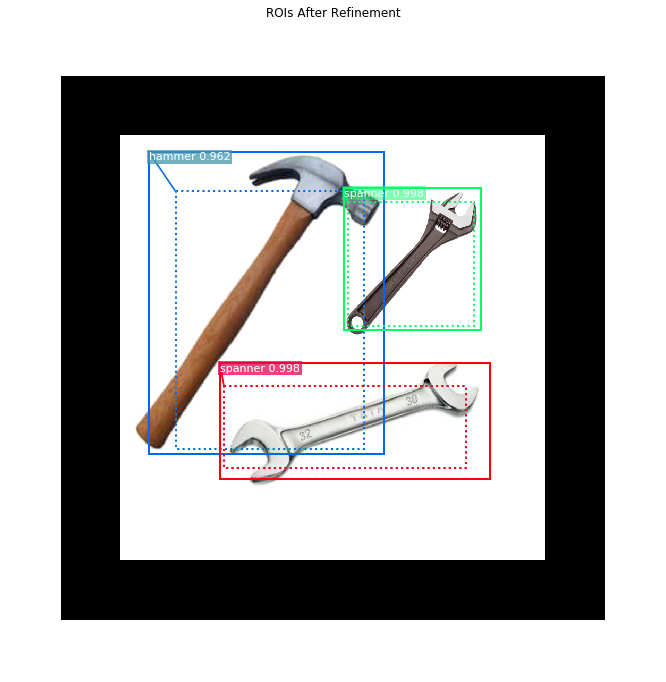

In [24]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset_val.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [25]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 3 detections:
[0 2 5]


In [26]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.7 confidence. Keep 3:
[0 2 5]


#### Per-Class Non-Max Suppression

In [27]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset_val.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

hammer                : [0] -> [0]
spanner               : [2 5] -> [2 5]

Kept after per-class NMS: 3
[0 2 5]


### Show final detections

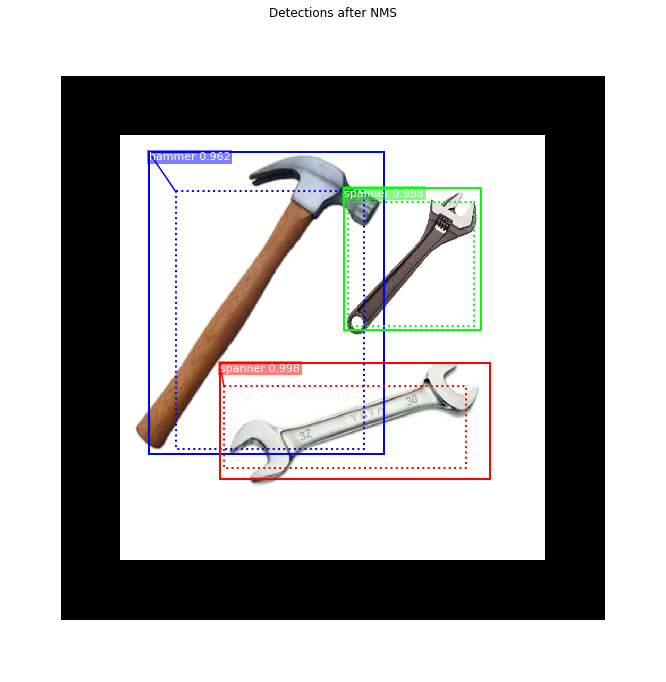

In [29]:

ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset_val.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

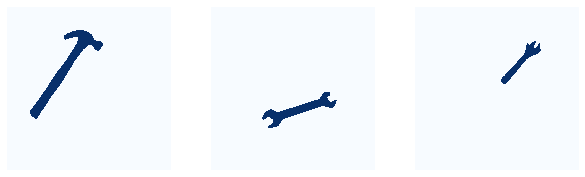

In [30]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [31]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset_val.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    2.00000  float32
masks                    shape: (1, 100, 28, 28, 3)   min:    0.00000  max:    0.99995  float32
3 detections: ['spanner' 'spanner' 'hammer']


In [32]:
# Masks  
det_boxes = denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (3, 28, 28)           min:    0.00000  max:    0.99986  float32
det_masks                shape: (3, 1024, 1024)       min:    0.00000  max:    1.00000  bool


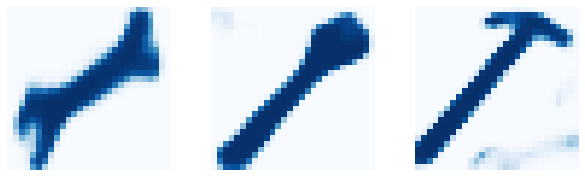

In [33]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

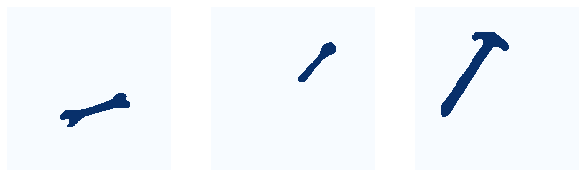

In [34]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")